(content:rv:quantiles)=
# quantile-based Distribution

In the following, let $X$ be a random variable that follows a distribution that is defined in terms of quantiles.
An outcome of $X$ is denoted as $x$.

## Syntax

```{eval-rst}
.. py:property:: quantiles

   Quantile-based distribution

   ``quantiles`` is a distribution type (:type:`flx_rv_type`) for :ref:`content:rv:basics` in Fesslix.

   Parametrization:
       The distribution expects a single parameter ``config`` of type *dict*. 
       The key-value pairs listed in the following can be specified in ``config``:

         - ``N_bins`` (*int*): the total number of bins; value must be positive.
         - ``q_vec`` (*numpy.ndarray*): A sorted (from small to large) vector of quantiles that are used to define the CDF of the distribution. The size of the array must equal ``N_bins+1``.
         - ``p_vec`` (*numpy.ndarray*): A vector of probabilities associated with the quantiles specified in ``q_vec``. The first value must be *zero* and the last value *one*.
         - ``use_tail_fit`` (*bool*, default: *False*): If *False*, the first and last bin are treated as any other bin. If *True*, special models for the tails are considered.
         - ``tail_lower`` (*dict*): Configuration dictionary for the lower tail. The structure of the *dict* corrsponds to the one returned by :func:`fesslix.tools.fit_tail_to_data`.
         - ``tail_upper`` (*dict*): Configuration dictionary for the upper tail. The structure of the *dict* corrsponds to the one returned by :func:`fesslix.tools.fit_tail_to_data`.
         - ``interpol`` (:type:`Word`, default:``uniform``): Mode of interpolation between the quantile values. The following interpolation modes are supported:

                 - ``uniform``: The PDF inside a bin is uniform (i.e., constant).
                 - ``pchip``: The PCHIP interpolant takes non-equispaced data and interpolates between them via cubic Hermite polynomials whose slopes are chosen so that the resulting interpolant is monotonic.
                 - ``bin_beta``: Each bin is modeled by a separate beta distribution. The parameters of the beta distributions need to be specified as entry ``bin_rvbeta_params`` in ``config``, where ``bin_rvbeta_params`` is a *numpy.ndarray* of size ``N_bins*2``. The parameter ``bin_rvbeta_params`` is provided by default by :func:`fesslix.tools.discretize_x_from_data`.
                 - ``bin_linear``: Each bin is modeled by a separately by a linear function. The gradients of the bins need to be specified as entry ``bin_rvlinear_params`` in ``config``, where ``bin_rvlinear_params`` is a *numpy.ndarray* of size ``N_bins``. The parameter ``bin_rvlineara_params`` is provided by default by :func:`fesslix.tools.discretize_x_from_data`.
                 - ``pdf_linear``: Linear interpolation is used to represent the PDF of the distribution. Therefore, the values in ``p_vec`` are NOT used in this case. Instead, values of the PDF associated with the values in ``q_vec`` need to be specified as entry ``pdf_vec`` in ``config``, where ``pdf_vec`` is a *numpy.ndarray* of size ``N_bins+1``. In order to generate parameter ``pdf_vec``, the function :func:`fesslix.tools.fit_pdf_based_on_qvec` needs to be called.

   .. admonition:: Hint
      :class: hint

      To generate a quantile-based distribution based on data (e.g., random samples), 
      the function :func:`fesslix.tools.discretize_x_from_data` can be used; 
      this function takes a data-array as input and returns a *dict*-object 
      that can directly be used to generate a quantile-based random variable.

```

## Example

### use the default discretization of data into bins

Initially, we start the engine, load the required modules and define some helping functions.

In [1]:
import fesslix as flx
flx.load_engine()

import fesslix.tools
import fesslix.plot
import fesslix.model_templates 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def test_rv(rv,throw=True):
    for p in [1e-6,1e-3,1e-2,0.05,0.33,0.5,0.66,0.95,1-1e-2,1.-1e-3,1.-1e-6]:
        x = rv.icdf(p)
        p_ = rv.cdf(x)
        print(f"{p:10.4e}, {p_:10.4e}, {x:8.2f}")
        if throw:
            p_ref = min(p,1.-p)
            if abs(p-p_)/p_ref>1e-3:
                raise NameError(f"ERROR 202504281221")
rv_lst = [ ]

Random Number Generator: MT19937 - initialized with rand()=1088599053;
Random Number Generator: MT19937 - initialized with 1000 initial calls.


Let's generate some data to work with:

In [2]:
## ==============================================
## Generate model
## ==============================================
my_model = fesslix.model_templates .generate_reliability_R_S_example()

## ==============================================
## Set up dataBox
## ==============================================
dBox_1 = flx.dataBox(my_model['sampler'].get_NOX(),len(my_model['model']))

## ----------------------------------------
## set up storing data in memory
## ----------------------------------------
dBox_1.write2mem( {
    'N_reserve': int(1e6),
    'cols': 'all'
    } )

## ==============================================
## Perform the Monte Carlo simulation
## ==============================================
my_model['sampler'].perform_MCS(40000,my_model['model'],dBox_1)

## ==============================================
## Extract a data-column from dBox_1
## ==============================================
data_fvec = dBox_1.extract_col_from_mem( { 'set':'out', 'id':0} )

Next, we process to generated sample data into bins. 

In [3]:
rv_q_config = fesslix.tools.discretize_x_from_data(data_fvec)
print(rv_q_config['N_bins'])

34


The obtained Python *dict* can be directly used to define a random variable that follows a quantile-based distribution.

In [4]:
rv_q_config['name'] = "default" ## specify a name (optional)
rv_0 = flx.rv(rv_q_config)
test_rv(rv_0)
rv_lst.append(rv_0)

1.0000e-06, 1.0000e-06,    -9.50
1.0000e-03, 1.0000e-03,    -2.62
1.0000e-02, 1.0000e-02,    -1.14
5.0000e-02, 5.0000e-02,     0.35
3.3000e-01, 3.3000e-01,     3.01
5.0000e-01, 5.0000e-01,     4.00
6.6000e-01, 6.6000e-01,     4.91
9.5000e-01, 9.5000e-01,     7.75
9.9000e-01, 9.9000e-01,     9.39
9.9900e-01, 9.9900e-01,    11.26
1.0000e+00, 1.0000e+00,    14.89


Let's plot the PDF of the distribution:

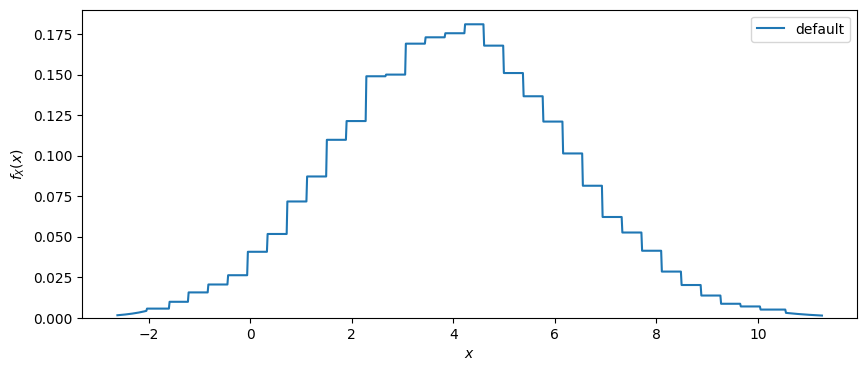

In [5]:
def gen_PDF():
    fig, ax = plt.subplots(figsize=(10, 4))
    
    for rv in rv_lst:
        fesslix.plot.draw_pdf(ax, rv, config_dict={'label':rv.get_name()}) 
        
    ax.set_ylim([0., None])
    plt.xlabel(r"$x$")
    plt.ylabel(r"$f_X(x)$")
    plt.legend()
    plt.show()
gen_PDF()

... and the CDF:

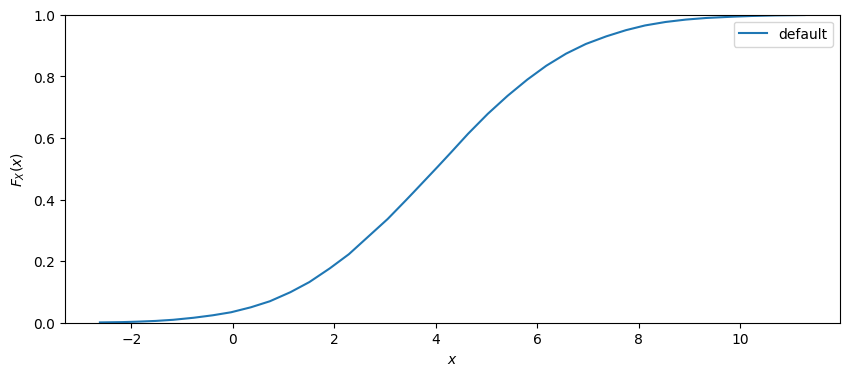

In [6]:
def gen_CDF():
    fig, ax = plt.subplots(figsize=(10, 4))

    for rv in rv_lst:
        fesslix.plot.draw_cdf(ax, rv, config_dict={'label':rv.get_name()}) 
        
    ax.set_ylim([0., 1.])
    plt.xlabel(r"$x$")
    plt.ylabel(r"$F_X(x)$")
    plt.legend()
    plt.show()
gen_CDF()

To change the type of interpolation to a linear interpolation of the PDF.
For this, we need to call {func}`fesslix.tools.fit_pdf_based_on_qvec`.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 87787.55880294128
            Iterations: 68
            Function evaluations: 2288
            Gradient evaluations: 68
1.0000e-06, 1.0000e-06,    -9.50
1.0000e-03, 1.0000e-03,    -2.62
1.0000e-02, 1.0000e-02,    -1.12
5.0000e-02, 5.0000e-02,     0.36
3.3000e-01, 3.3000e-01,     3.00
5.0000e-01, 5.0000e-01,     4.00
6.6000e-01, 6.6000e-01,     4.91
9.5000e-01, 9.5000e-01,     7.75
9.9000e-01, 9.9000e-01,     9.37
9.9900e-01, 9.9900e-01,    11.26
1.0000e+00, 1.0000e+00,    14.89


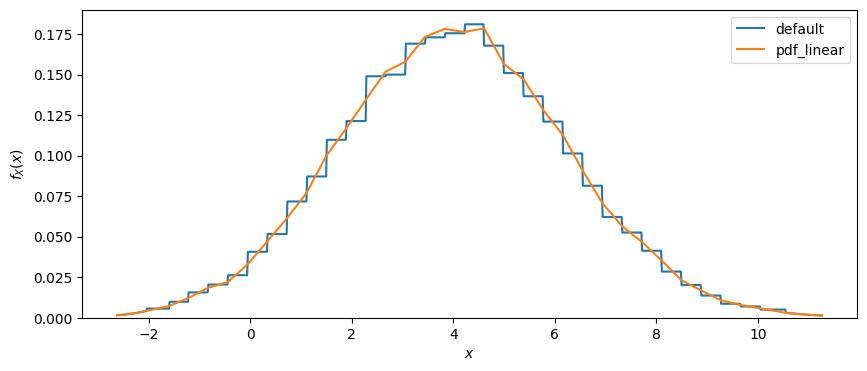

In [7]:
## extend rv_q_config
fesslix.tools.fit_pdf_based_on_qvec(data_fvec, rv_q_config)

## define the random variable
rv_q_config['name'] = "pdf_linear" ## specify a name (optional)
rv_1 = flx.rv(rv_q_config)

## test and plot the random variable
test_rv(rv_1)
rv_lst.append(rv_1)
gen_PDF()

Alternatively, PCHIP can be used for interpolation:

1.0000e-06, 1.0000e-06,    -9.50
1.0000e-03, 1.0000e-03,    -2.62
1.0000e-02, 9.9946e-03,    -1.13
5.0000e-02, 4.9990e-02,     0.36
3.3000e-01, 3.3001e-01,     3.01
5.0000e-01, 5.0000e-01,     4.00
6.6000e-01, 6.6001e-01,     4.91
9.5000e-01, 9.4999e-01,     7.75
9.9000e-01, 9.9000e-01,     9.38
9.9900e-01, 9.9900e-01,    11.26
1.0000e+00, 1.0000e+00,    14.89


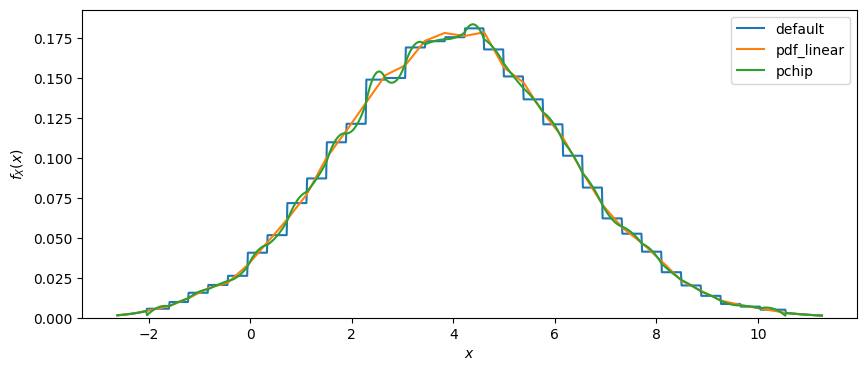

In [8]:
rv_q_config['interpol'] = 'pchip'
rv_q_config['name'] = "pchip" ## specify a name (optional)
rv_2 = flx.rv(rv_q_config)

## Note that the x2y- and y2x-transforms are not truly inverse functions of each other
## ... keep this in mind!
test_rv(rv_2,throw=False)
rv_lst.append(rv_2)
gen_PDF()

### modify the tail-model

To output the different tail-models available (for the upper tail):

In [9]:
for tmn, tmodel in rv_q_config['tail_upper']['models'].items():
    print(f"{tmn}: {tmodel['nll']}")

genpareto: 70.00820273643549
logn: 87.88850222858704


We can also use the log-Normal model for the upper and lower tail:

1.0000e-06, 1.0000e-06,  -121.51
1.0000e-03, 1.0000e-03,    -4.03
1.0000e-02, 1.0000e-02,    -1.12
5.0000e-02, 5.0000e-02,     0.36
3.3000e-01, 3.3000e-01,     3.00
5.0000e-01, 5.0000e-01,     4.00
6.6000e-01, 6.6000e-01,     4.91
9.5000e-01, 9.5000e-01,     7.75
9.9000e-01, 9.9000e-01,     9.37
9.9900e-01, 9.9900e-01,    12.72
1.0000e+00, 1.0000e+00,   136.22


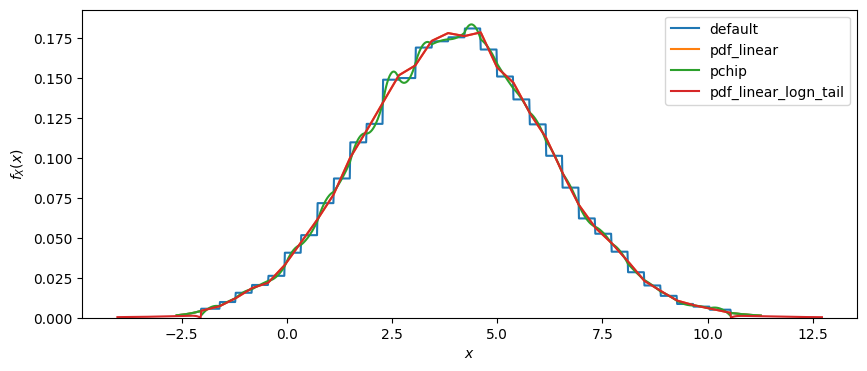

In [10]:
## define the random variable
rv_q_config['tail_upper']['use_model'] = 'logn'
rv_q_config['tail_lower']['use_model'] = 'logn'
rv_q_config['interpol'] = 'pdf_linear'
rv_q_config['name'] = "pdf_linear_logn_tail" ## specify a name (optional)
rv = flx.rv(rv_q_config)

## test and plot the random variable
test_rv(rv)
rv_lst.append(rv)
gen_PDF()

We can also specify aboslute lower and upper bounds. In this case the beta distribution is also available as a model for the tails.

genpareto: 70.00820273643549
logn: 87.88850222858704
beta: 70.00902305966775
1.0000e-06, 1.0000e-06,    -6.56
1.0000e-03, 1.0000e-03,    -2.68
1.0000e-02, 1.0000e-02,    -1.14
5.0000e-02, 5.0000e-02,     0.35
3.3000e-01, 3.3000e-01,     3.01
5.0000e-01, 5.0000e-01,     4.00
6.6000e-01, 6.6000e-01,     4.91
9.5000e-01, 9.5000e-01,     7.75
9.9000e-01, 9.9000e-01,     9.39
9.9900e-01, 9.9900e-01,    11.26
1.0000e+00, 1.0000e+00,    15.07


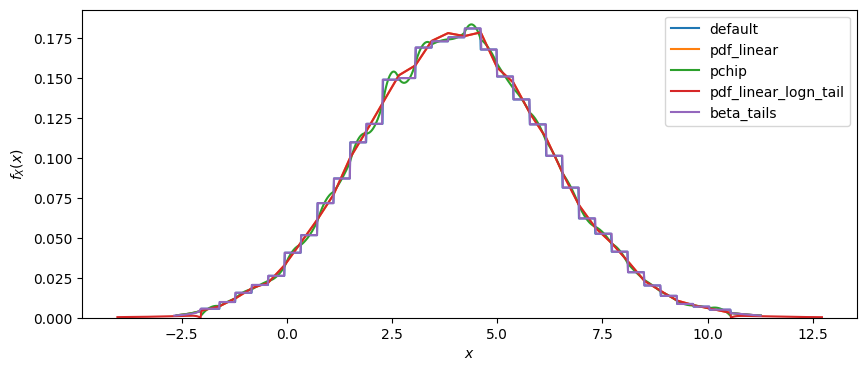

In [11]:
## re-run the discretization into bins - with fixed bounds.
rv_q_config = fesslix.tools.discretize_x_from_data(data_fvec, 
               lower_bound=-10., upper_bound=20.)

## output the tail models (for the upper tail)
for tmn, tmodel in rv_q_config['tail_upper']['models'].items():
    print(f"{tmn}: {tmodel['nll']}")
    
## define the random variable
rv_q_config['tail_upper']['use_model'] = 'beta'
rv_q_config['tail_lower']['use_model'] = 'beta'
rv_q_config['name'] = "beta_tails" ## specify a name (optional)
rv = flx.rv(rv_q_config)

## test and plot the random variable
test_rv(rv)
rv_lst.append(rv)
gen_PDF()

### modify the discretization into bins

You can also use a uniform distribution of samples into bins:

1.0000e-06, 1.0000e-06,    -6.10
1.0000e-03, 1.0000e-03,    -2.83
1.0000e-02, 1.0000e-02,    -1.12
5.0000e-02, 5.0000e-02,     0.32
3.3000e-01, 3.3000e-01,     3.01
5.0000e-01, 5.0000e-01,     4.00
6.6000e-01, 6.6000e-01,     4.91
9.5000e-01, 9.5000e-01,     7.79
9.9000e-01, 9.9000e-01,     9.37
9.9900e-01, 9.9900e-01,    11.29
1.0000e+00, 1.0000e+00,    14.85


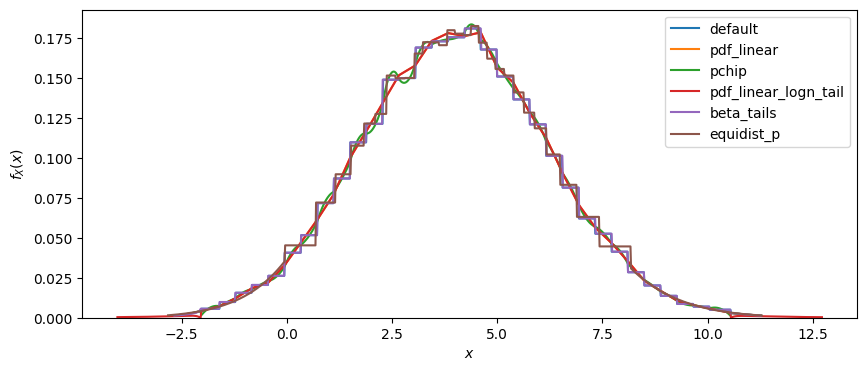

In [12]:
## perform discretization into bins and define the random variable
rv_q_config = fesslix.tools.discretize_x_from_data(data_fvec, config={
    'mode':'equidist_p',
    'N_bins': 30
    })
rv_q_config['name'] = "equidist_p" ## specify a name (optional)
rv = flx.rv(rv_q_config)

## test and plot the random variable
test_rv(rv)
rv_lst.append(rv)
gen_PDF()